<a href="https://colab.research.google.com/github/eduvaladao/aulas_escola_cbpf_XIII/blob/main/aula06_XIII_Escola_CBPF_Emisssion_galaxyPCAxAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

<font size="5"> PCA and Autoencoder
    
<font size="2">
    
This notebook was developed by Luciana Dias,  Gabriel Teixeira for the XIII Escola do CBPF - Curso de Introdução a Cosmologia com Python prof. Clécio R. Bom
<a href="www.clearnightsrthebest.com">clearnightsrthebest.com</a>
    
**Contact:** debom@cbpf.br</font>

<font size="2">

Please do not remove this disclaimer.</font>




In [ ]:
#!ls
#%cd "/content/" 
%matplotlib inline



In [ ]:
# import libraries

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import keras
import time
import tensorflow as tf
import timeit


import sys
import urllib
import urllib.request
import astropy

from astropy import stats
from astropy.stats import FitnessFunc
from scipy import linalg
from matplotlib import pyplot
#from google.colab import drive # import data google drive
from astropy.io import fits
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Input
from keras.layers import Dense, Flatten, Activation
from keras.models import Model
from keras import regularizers
from IPython.display import Image, display
from keras import backend as K
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn import neighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from astropy.stats import FitnessFunc
#from astroML.datasets import sdss_corrected_spectra
#from astroML.decorators import pickle_results
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import get_data_home
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pylab as pl
#%cd astroML
#from astroML.decorators import pickle_results
#from astroML.datasets.tools.cas_query import query_plate_mjd_fiber, TARGET_GALAXY
#from astroML.dimensionality import iterative_pca
#%cd ..


py3k = (sys.version_info[0] == 3)

if py3k:
    from urllib.request import urlopen
    from urllib.error import HTTPError
    from urllib.parse import urlencode
else:
    from urllib2 import urlopen
    from urllib2 import HTTPError
    from urllib import urlencode

if py3k:
    from io import StringIO, BytesIO
else:
    from cStringIO import StringIO
    from cStringIO import StringIO as BytesIO



# Download Data
**From: https://clearskiesrbest.files.wordpress.com/2019/02/spec4000.zip**

In [ ]:
# Modified from : https://github.com/astroML/astroML/blob/master/astroML/datasets/sdss_corrected_spectra.py
# Data source: https://github.com/astroML/astroML-data/raw/master/datasets/spec4000.npz

def fetch_sdss_corrected_spectra():
    """
    Parameters
    ----------
    data_home : optional, default=None
        Specify another download and cache folder for the datasets. By default
        all scikit learn data is stored in '~/astroML_data' subfolders.
    download_if_missing : optional, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.
    Returns
    -------
    data : NpzFile
        The data dictionary
    Notes
    -----
    This is the file created by the example script
    examples/datasets/compute_sdss_pca.py
    """
    !wget https://github.com/astroML/astroML-data/raw/master/datasets/spec4000.npz
      
    data = np.load('spec4000.npz')

    return data
  





In [ ]:
%cd "/content"
!rm -rf spec4000
!ls


/content
sample_data


# Compute the reconstructed spectra.

In [ ]:
# Modified from : https://github.com/astroML/astroML/blob/master/astroML/datasets/sdss_corrected_spectra.py
def reconstruct_spectra(data):
    """

    Parameters
    ----------
    data: NpzFile
        numpy data object returned by fetch_sdss_corrected_spectra.

    Returns
    -------
    spec_recons: ndarray
        Reconstructed spectra, using principal components to interpolate
        across the masked region.
    """
    spectra = data['spectra']
    coeffs = data['coeffs']
    evecs = data['evecs']
    mask = data['mask']
    mu = data['mu']
    norms = data['norms']

    spec_recons = spectra.copy()

    nev = coeffs.shape[1]

    spec_fill = mu + np.dot(coeffs, evecs[:nev])
    spec_fill *= norms[:, np.newaxis]

    spec_recons[mask] = spec_fill[mask]

    return spec_recons

# Compute the wavelength associated with spectra.

In [ ]:
# Modified from : https://github.com/astroML/astroML/blob/master/astroML/datasets/sdss_corrected_spectra.py
def compute_wavelengths(data):
    """

    Paramters
    ---------

    Parameters
    ----------
    data: NpzFile
        numpy data object returned by fetch_sdss_corrected_spectra.

    Returns
    -------
    wavelength: ndarray
        One-dimensional wavelength array for spectra.
    """
    ww = (10 ** (data['coeff0'] + data['coeff1'] * np.arange(data['spectra'].shape[1])))
          
    return ww

# Return a discrete colormap from the continuous colormap cmap.

In [ ]:
# Modified from : https://github.com/astroML/astroML/blob/master/astroML/plotting/tools.py
def discretize_cmap(cmap, N):
    """

    Parameters
    ----------
        cmap: colormap instance, eg. cm.jet.
        N: Number of colors.

    Returns
    -------
        cmap_d: discretized colormap

    Example
    -------
        >>> x = resize(arange(100), (5,100))
        >>> djet = cmap_discretize(cm.jet, 5)
    """

    cdict = cmap._segmentdata.copy()
    # N colors
    colors_i = np.linspace(0, 1., N)
    # N+1 indices
    indices = np.linspace(0, 1., N + 1)
    for key in ('red', 'green', 'blue'):
        # Find the N colors
        D = np.array(cdict[key])
        I = interpolate.interp1d(D[:, 0], D[:, 1])
        colors = I(colors_i)
        # Place these colors at the correct indices.
        A = np.zeros((N + 1, 3), float)
        A[:, 0] = indices
        A[1:, 1] = colors
        A[:-1, 2] = colors
        # Create a tuple for the dictionary.
        L = []
        for l in A:
            L.append(tuple(l))
        cdict[key] = tuple(L)
    # Return colormap object.
    return LinearSegmentedColormap('colormap', cdict, 1024)

# **Load and visualize Data**
**X , Y and wavelengths**

In [ ]:
# Modified from : http://www.astroml.org/book_figures/chapter7/fig_PCA_LLE.html
from matplotlib import pylab as plt
data = fetch_sdss_corrected_spectra()
spectra = reconstruct_spectra(data)
wavelengths = compute_wavelengths(data)

   
print(data)
X = spectra
X = preprocessing.normalize(X)
print(X.shape)
y = data['lineindex_cln']
print(y.shape) 
print(wavelengths.shape)

lst = data.files

# Visualize data item
#for item in lst:
    #print(item)
    #print(data[item])
    
clim = (1.5, 6.5)
cmap = discretize_cmap(plt.cm.jet, 5)
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])

# Fetch the data; PCA coefficients have been pre-computed
data = fetch_sdss_corrected_spectra()
coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']

color = data['lineindex_cln']

--2021-08-06 18:01:42--  https://github.com/astroML/astroML-data/raw/master/datasets/spec4000.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astroML/astroML-data/master/datasets/spec4000.npz [following]
--2021-08-06 18:01:43--  https://raw.githubusercontent.com/astroML/astroML-data/master/datasets/spec4000.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28466684 (27M) [application/octet-stream]
Saving to: ‘spec4000.npz’

spec4000.npz        100%[===================>]  27.15M  95.1MB/s    in 0.3s    

2021-08-06 18:01:45 (95.1 MB/s) - ‘spec4000.npz’ saved [28466684/28466684]

(4000, 1000

In [ ]:
!ls


sample_data  spec4000.npz  spec4000.npz.1


# Compute and visualize the LLE projection with plot PCA projection of Spectra 

 - finished LLE projection
 - removing 33 outliers for plot


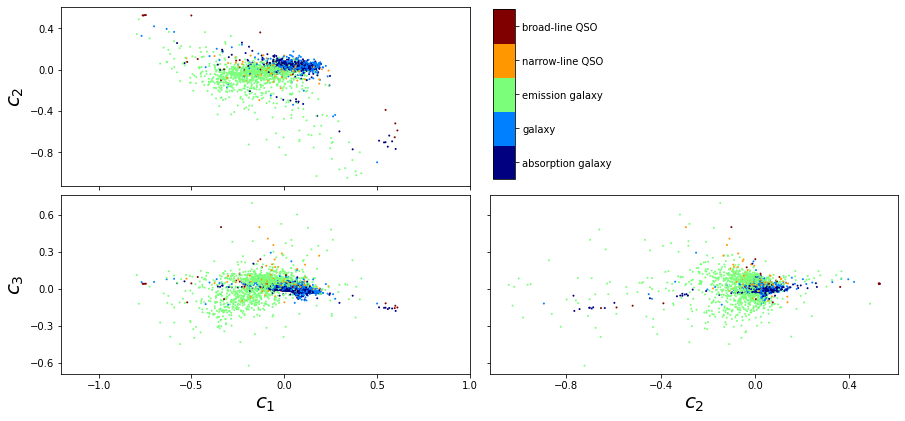

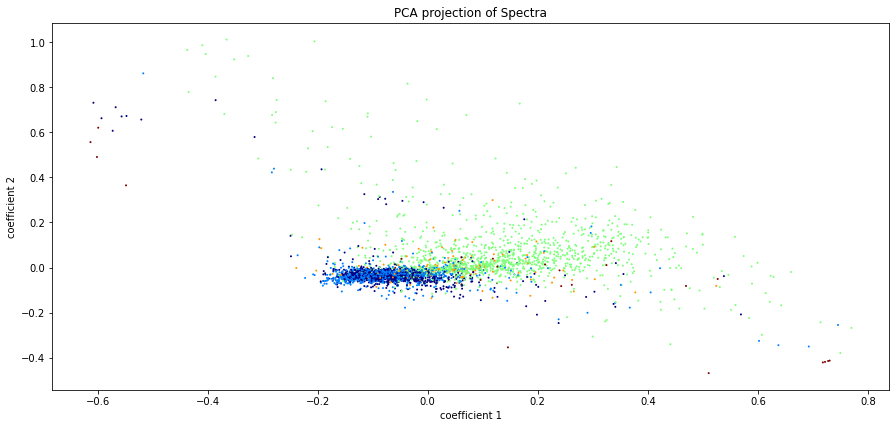

In [ ]:
### Modified from : http://www.astroml.org/book_figures/chapter7/fig_PCA_LLE.html

def compute_spec_LLE(n_neighbors, out_dim,spectra):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors, out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spectra)
    print(" - finished LLE projection")

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print(" - removing {0} outliers for plot".format(flag.sum()))

    return Y_LLE[~flag]#, color[~flag]

coeffs_LLE = compute_spec_LLE(10, 3, spectra)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA],
                             [coeffs_PCA],
                             [(-1.2, 1.0), (-0.01, 0.014)]):
    fig = plt.figure(figsize=(15, 6.75)) # change heights and widht
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$', fontsize=20)

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$', fontsize=20)
    ax2.set_ylabel('$c_3$', fontsize=20)

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$', fontsize=20)
    
    

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        
    

plt.show()

nP = 7
rpca = PCA(n_components=nP, random_state=0)
X_proj = rpca.fit_transform(X)


pl.figure(figsize=(15, 6.75))
pl.scatter(X_proj[:, 0], X_proj[:, 1], c=y, s=4, lw=0,
           vmin=2, vmax=6, cmap=pl.cm.jet)

pl.xlabel('coefficient 1')
pl.ylabel('coefficient 2')
pl.title('PCA projection of Spectra')
pl.savefig('plotProjSpec.png')


# **Plots**

In [ ]:
import matplotlib.pyplot as plt

target_names = cdict


#Modify from: https://towardsdatascience.com/pca-vs-autoencoders-1ba08362f450
def plot3clusters(X, title, vtitle):
    plt.figure(figsize=(15, 6.75))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=4, lw=0,
                vmin=2, vmax=6, cmap=pl.cm.jet)
  
    plt.xlabel('coefficient 1')
    plt.ylabel('coefficient 2')
    plt.title(title)
    plt.savefig(title + '.png')

    plt.colorbar(ticks=cticks,
                 format=formatter)





In [ ]:
# Modified from: https://github.com/astroML/astroML/blob/master/astroML/datasets/tools/cas_query.py
# and https://github.com/astroML/astroML/blob/master/astroML/datasets/tools/sql_query.py

PUBLIC_URL = 'http://cas.sdss.org/public/en/tools/search/x_sql.aspx'
DEFAULT_FMT = 'csv'

def remove_sql_comments(sql):
    """Strip SQL comments starting with --"""
    return ' \n'.join(map(lambda x: x.split('--')[0], sql.split('\n')))


  
def sql_query(sql_str, url=PUBLIC_URL, format='csv'):
    """Execute query
    Parameters
    ----------
    sql_str : string
        valid sql query
    url: string (optional)
        query url.  Default is http://cas.sdss.org query script
    format: string (default='csv')
        query output format
    Returns
    -------
    F: file object
        results of the query
    """
    sql_str = remove_sql_comments(sql_str)
    params = urlencode(dict(cmd=sql_str, format=format))
    return urlopen(url + '?%s' % params)
  
  

# SDSS primtarget codes
TARGET_QSO_HIZ            = int('0x00000001', 16)
TARGET_QSO_CAP	          = int('0x00000002', 16)
TARGET_QSO_SKIRT	  = int('0x00000004', 16)
TARGET_QSO_FIRST_CAP	  = int('0x00000008', 16)
TARGET_QSO_FIRST_SKIRT    = int('0x00000010', 16)
TARGET_GALAXY_RED	  = int('0x00000020', 16)
TARGET_GALAXY	          = int('0x00000040', 16)
TARGET_GALAXY_BIG	  = int('0x00000080', 16)
TARGET_GALAXY_BRIGHT_CORE = int('0x00000100', 16)
TARGET_ROSAT_A            = int('0x00000200', 16)
TARGET_ROSAT_B            = int('0x00000400', 16)
TARGET_ROSAT_C            = int('0x00000800', 16)
TARGET_ROSAT_D            = int('0x00001000', 16)
TARGET_STAR_BHB           = int('0x00002000', 16)
TARGET_STAR_CARBON        = int('0x00004000', 16)
TARGET_STAR_BROWN_DWARF   = int('0x00008000', 16)
TARGET_STAR_SUB_DWARF     = int('0x00010000', 16)
TARGET_STAR_CATY_VAR      = int('0x00020000', 16)
TARGET_STAR_RED_DWARF     = int('0x00040000', 16)
TARGET_STAR_WHITE_DWARF   = int('0x00080000', 16)
TARGET_SERENDIP_BLUE      = int('0x00100000', 16)
TARGET_SERENDIP_FIRST     = int('0x00200000', 16)
TARGET_SERENDIP_RED       = int('0x00400000', 16)
TARGET_SERENDIP_DISTANT   = int('0x00800000', 16)
TARGET_SERENDIP_MANUAL    = int('0x01000000', 16)
TARGET_QSO_FAINT          = int('0x02000000', 16)
TARGET_GALAXY_RED_II      = int('0x04000000', 16)
TARGET_ROSAT_E            = int('0x08000000', 16)
TARGET_STAR_PN            = int('0x10000000', 16)
TARGET_QSO_REJECT = int('0x20000000', 16)  

DEFAULT_TARGET = TARGET_GALAXY  # main galaxy sample


def query_plate_mjd_fiber(n_spectra,
                          primtarget=DEFAULT_TARGET,
                          zmin=0, zmax=0.7):
    """Query the SDSS server for plate, mjd, and fiber numbers
    Parameters
    ----------
    n_spectra: int
        number of spectra to query.  Max is 100,000 (set by CAS server)
    primtarget: int
        prime target flag.  See notes below
    zmin, zmax: float
        minimum and maximum redshift range for query
    Returns
    -------
    plate, mjd, fiber : ndarrays, size=n_spectra
        The plate numbers MJD, and fiber numbers of the spectra
    Notes
    -----
    Primtarget flag values can be found at
    http://cas.sdss.org/dr7/en/help/browser/enum.asp?n=PrimTarget
    """
    query_text = '\n'.join(("SELECT TOP %(n_spectra)i ",
                            "  plate, mjd, fiberid ",
                            "FROM specObj ",
                            "WHERE ((PrimTarget & %(primtarget)i) > 0) ",
                            "       AND (z > %(zmin)f)",
                            "       AND (z <= %(zmax)f) ")) % locals()

    output = sql_query(query_text).readlines()
    keys = output[0]

    res = np.zeros((n_spectra, 3), dtype=int)
    for i, line in enumerate(output[2:]):
        try:
            res[i] = line.decode().strip().split(',')
        except BaseException:
            assert 0
            raise ValueError(b'\n'.join(output))

    ntot = i + 1

    return res[:ntot].T

In [ ]:
# modify: https://github.com/astroML/astroML/blob/master/astroML/dimensionality/iterative_pca.py
def iterative_pca(X, M, n_ev=5, n_iter=15, norm=None, full_output=False):
    """
    Parameters
    ----------
    X: ndarray, shape = (n_samples, n_features)
        input data
    M: ndarray, bool, shape = (n_samples, n_features)
        mask for input data.  where mask == True, the spectrum is unconstrained
    n_ev: int
        number of eigenvectors to use in reconstructing masked regions
    n_iter: int
        number of iterations to find eigenvectors
    norm: string
        what type of normalization to use on the data. Options are
        - None : no normalization
        - 'L1' : L1-norm
        - 'L2' : L2-norm
    full_output: boolean (optional)
        if False (default) return only the reconstructed data X_recons
        if True, return the full information (see below)
    Returns
    -------
    X_recons: ndarray, shape = (n_samples, n_features)
        data with masked regions reconstructed
    mu: ndarray, shape = (n_features,)
        mean of data
    evecs: ndarray, shape = (min(n_samples, n_features), n_features)
        eigenvectors of the reconstructed data
    evals: ndarray, size = min(n_samples, n_features)
        eigenvalues of the reconstructed data
    norms: ndarray, size = n_samples
        normalization of each input
    coeffs: ndarray, size = (n_samples, n_ev)
        coefficients used to reconstruct X
    """
    X = np.asarray(X, dtype=np.float)
    M = np.asarray(M, dtype=np.bool)

    if X.shape != M.shape:
        raise ValueError('X and M must have the same shape')

    n_samples, n_features = X.shape

    if np.any(M.sum(0) == n_samples):
        raise ValueError('Some features are masked in all samples')

    if type(norm) == str:
        norm = norm.upper()

    if norm not in (None, 'none', 'L1', 'L2'):
        raise ValueError('unrecognized norm: %s' % norm)

    notM = (~M)

    X_recons = X.copy()
    X_recons[M] = 0

    # as an initial guess, we'll fill-in masked regions with the mean
    # of the rest of the sample
    if norm is None:
        mu = (X_recons * notM).sum(0) / notM.sum(0)
        mu = mu * np.ones([n_samples, 1])
        X_recons[M] = mu[M]
    else:
        # since we're normalizing each spectrum, and the norm depends on
        # the filled-in values, we need to iterate a few times to make
        # sure things are consistent.
        for i in range(n_iter):
            # normalize
            if norm == 'L1':
                X_recons /= np.sum(X_recons, 1)[:, None]
            else:
                X_recons /= np.sqrt(np.sum(X_recons ** 2, 1))[:, None]

            # find the mean
            mu = (X_recons * notM).sum(0) / notM.sum(0)
            mu = mu * np.ones([n_samples, 1])
            X_recons[M] = mu[M]

    # Matrix of coefficients
    coeffs = np.zeros((n_samples, n_ev))

    # Now we iterate through, using the principal components to reconstruct
    #  these regions.
    for i in range(n_iter):
        sys.stdout.write(' PCA iteration %i / %i\r' % (i + 1, n_iter))
        sys.stdout.flush()

        # normalize the data
        if norm == 'L1':
            X_recons /= np.sum(X_recons, 1)[:, None]
        else:
            X_recons /= np.sqrt(np.sum(X_recons ** 2, 1))[:, None]

        # now compute the principal components
        mu = X_recons.mean(0)
        X_centered = X_recons - mu
        U, S, VT = np.linalg.svd(X_centered, full_matrices=False)

        # perform a least-squares fit to estimate the coefficients of the
        # first n_ev eigenvectors for each data point.
        # The eigenvectors are in the rows of the matrix VT.
        # The coefficients are given by
        #  a_n = [V_n^T W V_n]^(-1) V_n W x
        # Such that x can be reconstructed via
        #  x_n = V_n a_n
        # Variables here are:
        #  x   : vector length n_features. This is a data point to be
        #        reconstructed
        #  a_n : vector of length n.  These are the reconstruction weights
        #  V_n : eigenvector matrix of size (n_features, n).
        #  W   : diagonal weight matrix of size (n_features, n_features)
        #        such that W[i,i] = M[i]
        #  x_n : vector of length n_features which approximates x
        VWx = np.dot(VT[:n_ev], (notM * X_centered).T)
        for i in range(n_samples):
            VWV = np.dot(VT[:n_ev], (notM[i] * VT[:n_ev]).T)
            coeffs[i] = solve(VWV, VWx[:, i], sym_pos=True, overwrite_a=True)

        X_fill = mu + np.dot(coeffs, VT[:n_ev])
        X_recons[M] = X_fill[M]
    sys.stdout.write('\n')

    # un-normalize X_recons
    norms = np.zeros(n_samples)
    for i in range(n_samples):
        ratio_i = X[i][notM[i]] / X_recons[i][notM[i]]
        norms[i] = ratio_i[~np.isnan(ratio_i)][0]
        X_recons[i] *= norms[i]

    if full_output:
        return X_recons, mu, VT, S, norms, coeffs
    else:
        return X_recons

# **Linear AE x PCA**

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 21        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
None
Wait training...


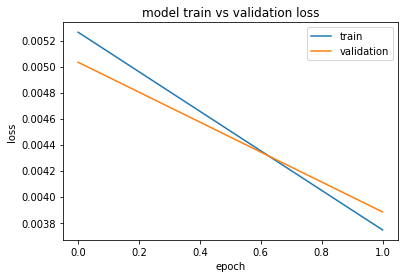

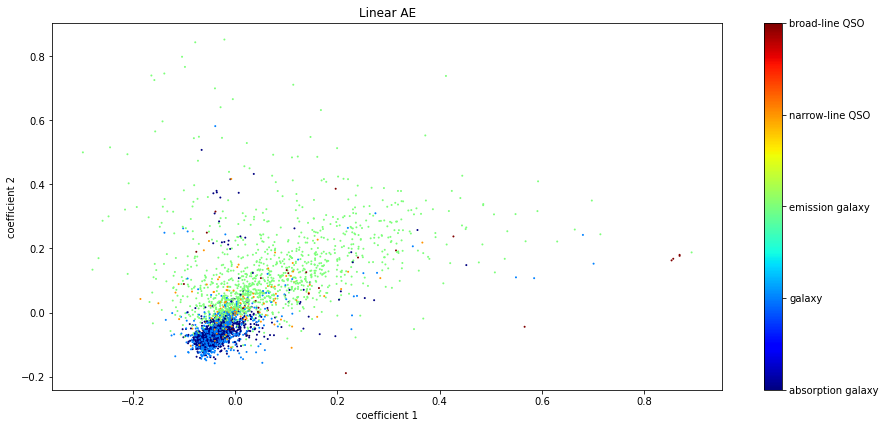

In [ ]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
X_scaled = X_proj
input_dim = X_scaled.shape[1]
encoding_dim = 2  
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='linear')(input_img)
decoded = Dense(input_dim, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

#1000
print('Wait training...')
history = autoencoder.fit(X_scaled, X_scaled,
                epochs=2,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('PlotLossFALinear1000EP.png')

# use our encoded layer to encode the training input
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X_scaled)

plot3clusters(encoded_data[:,:4], 'Linear AE', 'AE')

# **Non-Linear sigmoid-based AE x PCA**

In [ ]:
keras.backend.clear_session() # clear before layers

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 21        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
None
Wait training...


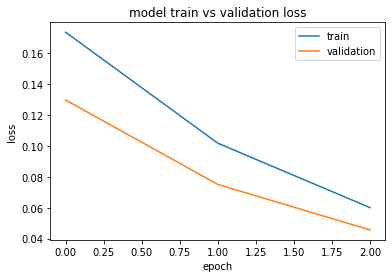

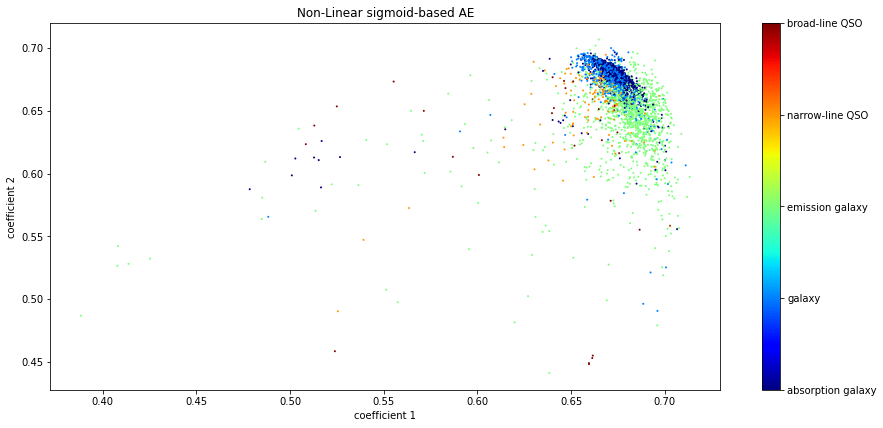

In [ ]:

#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim2 = X_scaled.shape[1]
encoding_dim2 = 2  
input_img2 = Input(shape=(input_dim2,))
encoded2 = Dense(encoding_dim2, activation='sigmoid')(input_img2)
decoded2 = Dense(input_dim2, activation='sigmoid')(encoded2)
autoencoder2 = Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mse')
print(autoencoder2.summary())

print('Wait training...')
#2000
history2 = autoencoder2.fit(X_scaled, X_scaled,
                epochs=3,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('PlotLossFASigm2000EP.png')

# use our encoded layer to encode the training input
encoder2 = Model(input_img2, encoded2)
encoded_input2 = Input(shape=(encoding_dim2,))
decoder_layer2 = autoencoder2.layers[-1]
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))
encoded_data2 = encoder2.predict(X_scaled)

plot3clusters(encoded_data2[:,:4], 'Non-Linear sigmoid-based AE', 'AE') 

# **Non-Linear relu-based AE x PCA**

In [ ]:
keras.backend.clear_session() # clear before layers

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 21        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
None
Wait training...


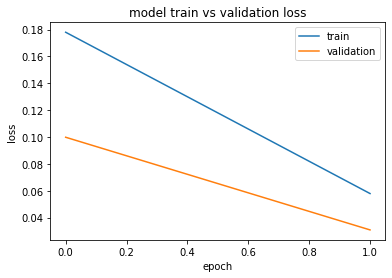

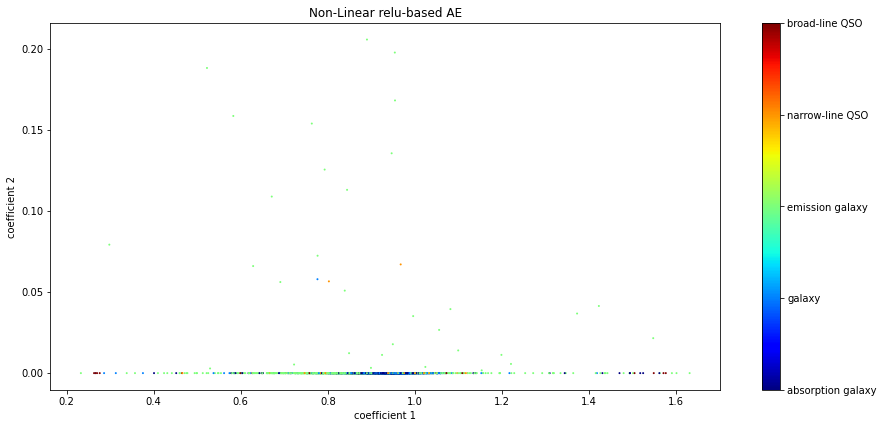

In [ ]:
#create an AE and fit it with our data using 3 neurons in the dense layer using keras' functional API
input_dim3 = X_scaled.shape[1]
encoding_dim3 = 2  
input_img3 = Input(shape=(input_dim3,))
encoded3 = Dense(encoding_dim3, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img3)
decoded3 = Dense(input_dim3, activation='sigmoid')(encoded3)
autoencoder3 = Model(input_img3, decoded3)
autoencoder3.compile(optimizer='adam', loss='mse')
print(autoencoder3.summary())

print('Wait training...')
#400
history3 = autoencoder3.fit(X_scaled, X_scaled,
                epochs=1000,
                batch_size=8,
                shuffle=True,
                validation_split=0.1,
                verbose = 0)

#plot our loss 
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('PlotLossFAReluSigm400EP.png')

# use our encoded layer to encode the training input
encoder3 = Model(input_img3, encoded3)
encoded_input3 = Input(shape=(encoding_dim3,))
decoder_layer3 = autoencoder3.layers[-1]
decoder3 = Model(encoded_input3, decoder_layer3(encoded_input3))
encoded_data3 = encoder3.predict(X_scaled)

plot3clusters(encoded_data3[:,:4], 'Non-Linear relu-based AE', 'AE') 

# **Results**

In [ ]:

labels_true = y 
titles = ['PCA', 'Linear AE', 'Sigmoid AE', 'Relu AE']
for n_clusters_ in [2,3]:
  estimators = [('PCA'    , KMeans(n_clusters=n_clusters_), X_proj),
                ('AE linear' , KMeans(n_clusters=n_clusters_), encoded_data),
                ('AE sigmoid' , KMeans(n_clusters=n_clusters_), encoded_data2),
                ('AE relu', KMeans(n_clusters=n_clusters_), encoded_data3)]

  print(type(y))
  print('Number of clusters: %d' % n_clusters_)
  for name, est, data in estimators:
      X = data
      est.fit(X)
      labels = est.labels_
      print(name,':')
      print(labels[:]) 
      print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
      print("Completeness: %0.3f" % completeness_score(labels_true, labels))
      print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
      print("Adjusted Rand Index: %0.3f"
            % adjusted_rand_score(labels_true, labels))
      print("Adjusted Mutual Information: %0.3f"
            % adjusted_mutual_info_score(labels_true, labels))
      #print(X)
      asss = np.sum(labels)
      if asss > 0:
      	 print("Silhouette Coefficient: %0.3f"
               % silhouette_score(X, labels))
      else:
         print("Silhouette Coefficient: 0")
               
      print()
  print()
  print('----------------------------------------------------------------------------------')
  print()



<class 'numpy.ndarray'>
Number of clusters: 2
PCA :
[1 0 0 ... 1 0 0]
Homogeneity: 0.169
Completeness: 0.405
V-measure: 0.238
Adjusted Rand Index: 0.163
Adjusted Mutual Information: 0.237
Silhouette Coefficient: 0.524

AE linear :
[0 1 1 ... 0 1 1]
Homogeneity: 0.146
Completeness: 0.391
V-measure: 0.213
Adjusted Rand Index: 0.114
Adjusted Mutual Information: 0.212
Silhouette Coefficient: 0.675

AE sigmoid :
[1 0 0 ... 1 0 0]
Homogeneity: 0.117
Completeness: 0.324
V-measure: 0.172
Adjusted Rand Index: 0.091
Adjusted Mutual Information: 0.171
Silhouette Coefficient: 0.626

AE relu :
[0 1 1 ... 0 1 1]
Homogeneity: 0.092
Completeness: 0.205
V-measure: 0.127
Adjusted Rand Index: 0.108
Adjusted Mutual Information: 0.126
Silhouette Coefficient: 0.580


----------------------------------------------------------------------------------

<class 'numpy.ndarray'>
Number of clusters: 3
PCA :
[1 0 0 ... 1 0 0]
Homogeneity: 0.183
Completeness: 0.391
V-measure: 0.249
Adjusted Rand Index: 0.170
Adjuste